<a href="https://colab.research.google.com/github/johannes-kk/am207/blob/master/exercises/16_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAY 16: Understanding Neural Networks


### AM207: Advanced Scientific Computing

#### Instructor: Weiwei Pan

#### Due: October 27th, 11:59pm EST

**Names of Group Members**:

Nari Johnson njohnson@college.harvard.edu

From Matthieu Meeus to Everyone: (9:11 AM)
 Matthieu Meeus (matthieu_meeus@g.harvard.edu) 
From Johannes Kolberg to Everyone: (9:11 AM)
 Johannes Kolberg (johanneskolberg@g.harvard.edu ) 
From Maggie Wang to Everyone: (9:11 AM)
 Maggie Wang (maggiewang@college.harvard.edu) 
From Alex Spiride to Everyone: (9:11 AM)
 Alex Spiride - aspiride@college.harvard.edu 
From Will Seaton to Everyone: (9:11 AM)
 Will Seaton wseaton@g.harvard.edu

## Learning Goals:

1. Be able to translate simple neural networks into closed functional forms
2. Explore how to implement a neural network from scratch
3. Explore the effects of depth and width on the function class represented by the network


### Load necessary libraries

In [ ]:
from autograd import numpy as np
from autograd import scipy as sp
from autograd import grad
from autograd.misc.optimizers import adam, sgd
import matplotlib.pyplot as plt


## Problem 1: What Does a Neural Network Represent?
In this problem, we explore the functions that can be represented by neural networks.

**Exercise 1:** Given the following architecture,

<img src="https://i.ibb.co/k0chZvb/Untitled-11.png">

write out in closed form the function $g(x_1, x_2)$ represented by this neural network, given:

1. the activation function is RBF: $f(z) = \mathrm{exp}\{- \frac{z - \mu}{\sigma} \}$, where $\mu = 0$ and $\sigma = 1/2$, except on the output node, where the activation is the identity function.
2. denote the weight from the $i$-th node in layer $l$ to the $j$-th node in layer $l+1$ by $w^l_{ij}$

**Solution:**

$$ y = w^3_{1, 1} h^2_1 + w^3_{2, 1} h^2_2$$
$$ y = w^3_{1, 1} \mathrm{exp}\{- \frac{(w^2_{1, 1} h^1_1 + w^2_{2, 1} h^1_2 +  w^2_{3, 1} h^1_3 ) - \mu}{\sigma} \} + w^3_{2, 1} \mathrm{exp}\{- \frac{(w^2_{1, 2} h^1_1 + w^2_{2, 2} h^1_2 +  w^2_{3, 2} h^1_3 ) - \mu}{\sigma} \}$$
$$ y = w^3_{1, 1} \mathrm{exp}\{- \frac{(w^2_{1, 1} h^1_1 + w^2_{2, 1} h^1_2 +  w^2_{3, 1} h^1_3 ) - \mu}{\sigma} \} + w^3_{2, 1} \mathrm{exp}\{- \frac{(w^2_{1, 2} h^1_1 + w^2_{2, 2} h^1_2 +  w^2_{3, 2} h^1_3 ) - \mu}{\sigma} \}$$

TODO substitute for $f$

$$ y = w^3_{1, 1} \mathrm{exp}\{- \frac{(w^2_{1, 1} f(w^1_{1, 1} x_1 + w^1_{2, 1} x_2) + w^2_{2, 1} f(w^1_{1, 2} x_1 + w^1_{2, 2} x_2)  +  w^2_{3, 1} f(w^1_{1, 3} x_1 + w^1_{2, 3} x_2)  ) - \mu}{\sigma} \} + w^3_{2, 1} \mathrm{exp}\{- \frac{(w^2_{1, 2} f(w^1_{1, 1} x_1 + w^1_{2, 1} x_2)  + w^2_{2, 2} f(w^1_{1, 2} x_1 + w^1_{2, 2} x_2)  +  w^2_{3, 2} f(w^1_{1, 3} x_1 + w^1_{2, 3} x_2)  ) - \mu}{\sigma} \}$$



**Exercise 2:** If we want to use this network to perform regression, why is it important that the activation on the output node is the identity function? 

If we want to use this network for classification, what activation function should we use for the output node?

**Solution:**

*If we want to use this network to perform regression, why is it important that the activation on the output node is the identity function?*

If we want to perform regression, then it is important that our output's activation function $f$ has a co-domain of all real numbers so that our output $y$ can take any real value.  Many common activation functions "squash" the input into a limited co-domain: for example, sigmoid(x) can only return values between 0 and 1.  

*If we want to use this network for classification, what activation function should we use for the output node?*

For classification, we should use a sigmoid/logistic or softmax activation function for binary or multi-class classification respectively. Sigmoid activation functions ($\frac{e^x}{1+e^x}$) returns a value bounded between [0,1] that represents a probability of being a class label or not. Softmax ($\frac{e^x}{\sum_{j=1}^K e^x}$) is a generalization of the logistic function to multiple dimensions and outputs a value between [0,1] for each class indicating the probability of that class. 

## Problem 2: Implementing Neural Networks
In this problem, you are given an example of a neural network implementation and are tasked with extending it.

**Exercise 3:** Modify this implementation (or write your own from scratch) to allow for arbitrary architecture, i.e. any number of hidden layers with any number of hidden nodes in each layer. 

In [ ]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param=None):
        ''' Make objective functions: depending on whether or not you want to apply l2 regularization '''
        
        if reg_param is None:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                sum_error = np.sum(squared_error)
                return sum_error
            
            return objective, grad(objective)
            
        else:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error
            
            return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):
        ''' Wrapper for MLE through gradient descent '''
        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

In [ ]:
class Feedforward_New:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {
                       'nodes': np.array(architecture['nodes']),
                       #'H': architecture['width'],
                       #'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (
            (architecture['input_dim'])*architecture['nodes'][0] + architecture['nodes'][0]
            + (architecture['output_dim']*architecture['nodes'][-1] + architecture['output_dim'])
            + np.sum([architecture['nodes'][i]*architecture['nodes'][i+1] + architecture['nodes'][i+1] for i in range(len(architecture['nodes'])-1)])
        )     

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        #H = self.params['H']
        H = self.params['nodes'][0]
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T

        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        # parameters used so far
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for i in range(1, len(self.params['nodes'])):
            before = index
            H_1 = self.params['nodes'][i]
            H_0 = self.params['nodes'][i-1]
            W = weights[index:index + H_0 * H_1].T.reshape((-1, H_1, H_0))
            index += H_0 * H_1
            b = weights[index:index + H_1].T.reshape((-1, H_1, 1))
            index += H_1

            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H_1

        H = self.params['nodes'][-1]

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))

        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param=None):
        ''' Make objective functions: depending on whether or not you want to apply l2 regularization '''
        
        if reg_param is None:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                sum_error = np.sum(squared_error)
                return sum_error
            
            return objective, grad(objective)
            
        else:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error
            
            return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):
        ''' Wrapper for MLE through gradient descent '''
        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']
        print('Got here')
        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)
        print('Got here 2')
        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5
        
        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

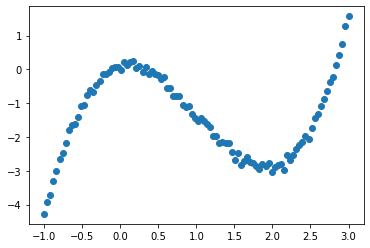

In [ ]:
# generate some toy regression data
x = np.linspace(-1, 3, 100)
f = lambda x: x**3 - 3 * x**2 + 0.5 * x + 0.1
y = f(x) + np.random.normal(0, 0.1, size=len(x))
plt.scatter(x, y)

In [ ]:
###define rbf activation function
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
input_dim = 1
output_dim = 1

architecture = {
               'nodes': [4, 8, 2],
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward_New(architecture, random=random)

In [ ]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':2000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)

Got here
Got here 2
Iteration 0 lower bound 185.91198604082228; gradient mag: 248.39040675714142
Iteration 100 lower bound 89.84328988572126; gradient mag: 130.9035777602093
Iteration 200 lower bound 62.7042477851679; gradient mag: 75.62681722897722
Iteration 300 lower bound 45.69854455073961; gradient mag: 56.835658936378834
Iteration 400 lower bound 34.40870548997323; gradient mag: 42.46441915122807
Iteration 500 lower bound 27.087440359923722; gradient mag: 31.478863703107418
Iteration 600 lower bound 21.952694239296232; gradient mag: 24.079806570995864
Iteration 700 lower bound 18.25411552732158; gradient mag: 20.141048508114956
Iteration 800 lower bound 15.221213266882284; gradient mag: 18.325130669693205
Iteration 900 lower bound 12.739967136433691; gradient mag: 16.516359999192307
Iteration 1000 lower bound 10.783677189876641; gradient mag: 14.567299067671517
Iteration 1100 lower bound 9.285178275903537; gradient mag: 12.636050082069108
Iteration 1200 lower bound 8.1655236994580

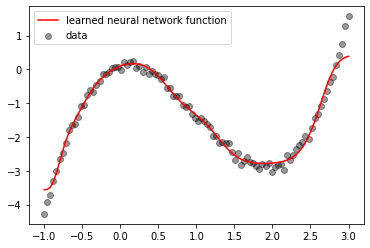

In [ ]:
y_pred = nn.forward(nn.weights, x.reshape((1, -1)))
plt.scatter(x, y, color='black', label='data', alpha=0.4)
plt.plot(x, y_pred.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()

Old implementation to verify consistency

In [ ]:
###define rbf activation function
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 2
input_dim = 1
output_dim = 1

architecture = {
               'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [ ]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':2000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)

Iteration 0 lower bound 317.8542988980625; gradient mag: 311.15305940272054
Iteration 100 lower bound 204.7376099855243; gradient mag: 194.57769095543333
Iteration 200 lower bound 119.82220516313264; gradient mag: 153.51582045304005
Iteration 300 lower bound 76.74039274002267; gradient mag: 107.80980196129336
Iteration 400 lower bound 55.69063342700742; gradient mag: 77.98394259810932
Iteration 500 lower bound 42.012784612761564; gradient mag: 61.21628810632166
Iteration 600 lower bound 30.39919366315006; gradient mag: 51.97418743022408
Iteration 700 lower bound 21.3647574737372; gradient mag: 39.446795651128845
Iteration 800 lower bound 15.27616762810277; gradient mag: 29.8777123580637
Iteration 900 lower bound 11.511025766667693; gradient mag: 21.61690333554667
Iteration 1000 lower bound 9.379582272724097; gradient mag: 15.48118427180661
Iteration 1100 lower bound 8.030226608608642; gradient mag: 11.980790759343
Iteration 1200 lower bound 7.025378708299957; gradient mag: 9.9527088614

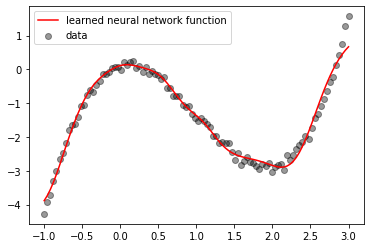

In [ ]:
y_pred = nn.forward(nn.weights, x.reshape((1, -1)))
plt.scatter(x, y, color='black', label='data', alpha=0.4)
plt.plot(x, y_pred.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()

**Exercise 4:** Experiment with your architecture to fit the data generated by our toy data generating function:
1. increasing the width while fixing the depth (the number of hidden layers) at 1.
2. increasing the depth while fixing the width (the number of hidden nodes in each layer) at 5.
3. increasing both width and depth.

From your experiments, describe the effect of network width on the function learned by your network. Describe the effect of width.

In order to capture an arbitrarily complex function what is more effective to adjust? Depth, width or both? You should test your hypothesis on other types of complex functions (e.g. sine, other polynomials etc).

In [ ]:
def experiment(widths, depths):
  preds = {0: [], 1: [], 2: []}

  for i in range(3):
    for width, hidden_layers in zip(widths[i], depths[i]):
      architecture = {'width': width,
                  'hidden_layers': hidden_layers,
                  'input_dim': input_dim,
                  'output_dim': output_dim,
                  'activation_fn_type': 'rbf',
                  'activation_fn_params': 'c=0, alpha=1',
                  'activation_fn': h}
      nn = Feedforward(architecture, random=random)
      nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)
      preds[i].append(nn.forward(nn.weights, x.reshape((1, -1))))

  from IPython.display import clear_output
  clear_output()

  print("Plot Guide:")
  print("Row #1: W = [1, 3, 5, 7, 12], D fixed to 1")
  print("Row #2: D = [1, 2, 3, 4, 10], W fixed to 5")
  print("Row #3: W = [1, 3, 5, 7, 12], D = [1, 2, 3, 4, 10]")
  print()

  fig, axs = plt.subplots(3, len(widths[0]), figsize=(15,7.5), sharex=True, sharey=True)
  for ax in axs.flat:
    ax.scatter(x, y, color='black', label='data', alpha=0.4)
  for j in range(len(widths[0])):
    axs[0,j].plot(x, preds[0][j].flatten(), color='red', label='learned neural network function')
    axs[0,j].set_title(f"W={widths[0][j]}", size=16)
  for j in range(len(widths[0])):
    axs[1,j].plot(x, preds[1][j].flatten(), color='red', label='learned neural network function')
    axs[1,j].set_title(f"D={depths[1][j]}", size=16)
  for j in range(len(widths[0])):
    axs[2,j].plot(x, preds[2][j].flatten(), color='red', label='learned neural network function')
    axs[2,j].set_title(f"W={widths[2][j]}, D={depths[2][j]}", size=16)

  axs[0,0].set_ylabel("D = 1", size=14)
  axs[1,0].set_ylabel("W = 5", size=14)
  axs[2,0].set_ylabel("Increasing Both", size=14)

  plt.tight_layout()
  plt.show()

Plot Guide:
Row #1: W = [1, 3, 5, 7, 12], D fixed to 1
Row #2: D = [1, 2, 3, 4, 10], W fixed to 5
Row #3: W = [1, 3, 5, 7, 12], D = [1, 2, 3, 4, 10]



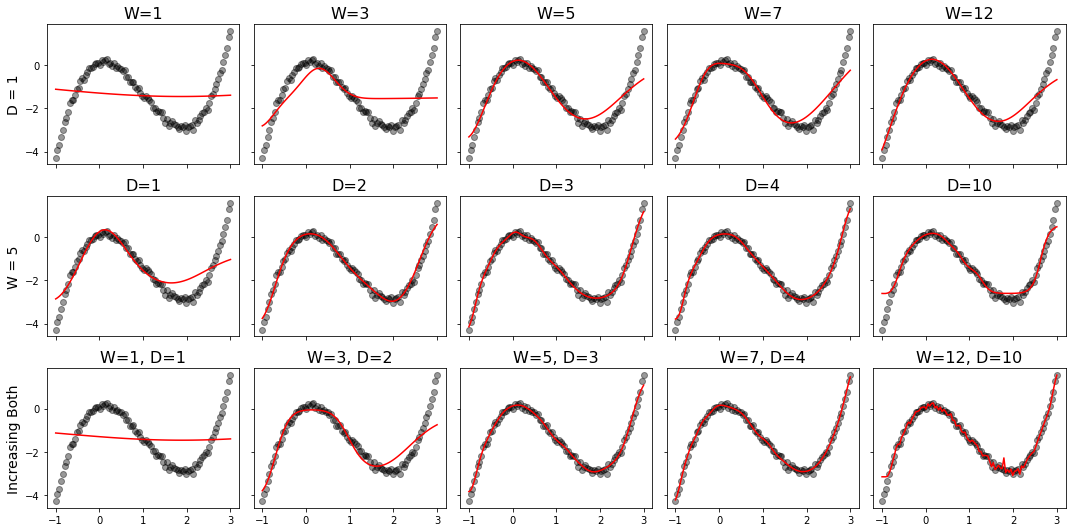

In [ ]:
experiment(
    widths = [[1, 3, 5, 7, 12], [5,5,5,5,5], [1, 3, 5, 7, 12]], 
    depths = [[1,1,1,1,1], [1, 2, 3, 4, 10], [1, 2, 3, 4, 10]]
)

Plot Guide:
Row #1: W = [1, 3, 5, 7, 12], D fixed to 1
Row #2: D = [1, 2, 3, 4, 10], W fixed to 5
Row #3: W = [1, 3, 5, 7, 12], D = [1, 2, 3, 4, 10]



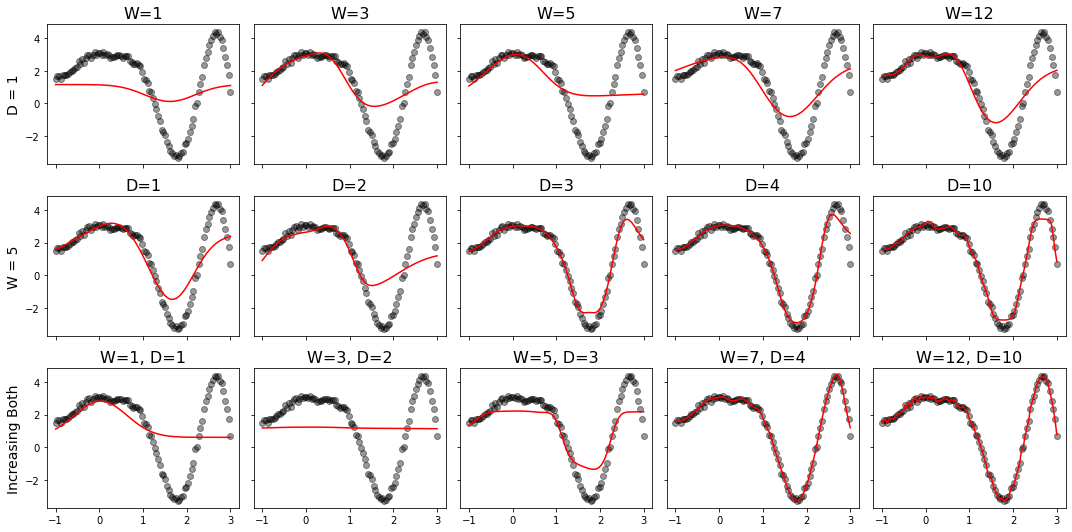

In [ ]:
# generate some toy regression data
x = np.linspace(-1, 3, 100)
f = lambda x: x**2 * np.sin(3*x) + 3 * np.cos(x)
y = f(x) + np.random.normal(0, 0.1, size=len(x))

experiment(
    widths = [[1, 3, 5, 7, 12], [5,5,5,5,5], [1, 3, 5, 7, 12]], 
    depths = [[1,1,1,1,1], [1, 2, 3, 4, 10], [1, 2, 3, 4, 10]]
)

**SOLUTION:** Increasing the network width seems to allow the network to learn more complex functions. As width increases (with depth constant or increasing also), the NN becomes more complex and can capture more of the curve.

It seems like depth is more effective than width at learning complex functions, but think this might be because the deep NN uses more parameters than the wide and shallow networks. We'd have to do more work to standardize the number parameters we have to learn to more accurately compare the two.